In [1]:
import numpy as np
import matplotlib.pyplot
%matplotlib inline
from numpy.linalg import *
import matplotlib.pyplot as plt
%matplotlib notebook
from time import *

In [2]:
def create_plot(p, mu, C):
    #% Visualisation of portfolios and assets in a sigma-mu-coordinate system
    #% (sigma is the standard deviation, mu is the expected return)
    #%
    #% INPUT
    #%=======================================
    #% p .......... matrix with portfolio weights in columns
    #% mu ......... column vector with expected returns for each asset
    #% C .......... variance-covariance matrix
    
    numb = np.shape(p)[1]
    sd = np.sqrt(np.diag(C))
    
    #Determine expected return and standard deviation of optimal portfolios
    rp = np.zeros(numb);
    sdp = np.zeros(numb);
    for i in range(0,numb):
        rp[i] = p[:,i]@mu;
        sdp[i] = np.sqrt(p[:,i].dot(C@p[:,i]));
    
    plt.scatter(sd,mu, label='Assests')
    plt.title('Assets and Efficient Portfolio(s)')
    plt.ylabel('expected return (annualized)')
    plt.xlabel('standard deviation')
    plt.scatter(sdp,rp, label='Efficient Portfolio(s)')
    plt.legend(loc = 4)
    plt.show()

In [3]:
#Method: Armijo-rule with fixed t=1 for quadratic convergence

def armijo_rule(fname, x, d, sigma=0.2, rho=0.4):
    #Input..........
    #fname....function: return of function value, gradient and hessian at x
    #x........Vector: current point
    #d........Vector: direction
    #sigma....Parameter: default=0.1
    #rho......Parameter: default=0.4
    #Output.........
    #t........scalar: stepwidth
    
    
    fvalue, fgrad, hesse = fname(x)
    skp = np.dot(d.transpose(),fgrad)
    t = 1
    while (fname(x+t*d)[0])>fvalue+t*sigma*skp:
        t = rho * t
        
    return t

#Method: Determine global solution of LCP 

def algorithmus1(f,x0,schrittw,A,tol):
    #Input...........
    #f..........target functio; function value, gradient and hessian
    #x0.........vector; feasible starting point for LCP
    #schrittw...function to determine stepwidth
    #A..........matrix with constraints
    #tol........parameter tolerance > 0
    #Output...........
    #x..........vector: approximation of global mini
    
    (m,n) = A.shape
    x = x0
    k = 1
    fvalue,fgrad,fhesse = f(x)
    
    #Calculate Linear sys
    #Create matrices
    a1 = np.concatenate((fhesse,A.transpose()),axis=1)
    a2 = np.concatenate((A,np.zeros([m,m])),axis=1)
    a3 = np.concatenate((a1,a2),axis=0)
    a4 = np.append((-fgrad),np.zeros(m))
    
    #calc Linear System
    q = np.linalg.solve(a3,a4)
    
    #direction are the first n entires of q
    d = np.squeeze(q[0:n])
    
    #As long as a certain step size is present and the maximum number of iterations has not been reached, x update
    while np.linalg.norm(d)>tol and k<50:
        
        #determine t 
        t = schrittw(f,x,d)
        
        #update x
        x = x+t*d
        fvalue,fgrad,fhesse = f(x)
        
        #determine d
        a1 = np.concatenate((fhesse,A.transpose()),axis=1)
        a2 = np.concatenate((A,np.zeros([m,m])),axis=1)
        a3 = np.concatenate((a1,a2),axis=0)
        a4 = np.append((-fgrad),np.zeros(m))
        q = np.linalg.solve(a3,a4)
        d = np.squeeze(q[0:n])
        k = k+1
        
    return x

In [4]:
#Function to return the logarithm for negative values
def log0(x):
    #Input...............
    #x......arguments of Logs (Vector)
    #Output..............
    #val....Modified log vals (Vector)
    n = x.size
    val = -np.ones(n)*float("inf")
    val[x>0] = np.log(x[x>0])
    return val

In [5]:
#Function to calculate a valid start vector
def startval(mu, beta):
    #input...............
    #mu.....Expected returns of assets (vector)
    #beta...Minimum expected return (scalar)
    #output.............................
    #val....Valid start vector for algorithm 2 (vector)
    n = mu.size
    i = np.argmax(mu)
    if (mu[i]<=beta):
        print('Strikt zulässige Menge leer')
    x0 = np.ones(n)/n
    while x0.dot(mu)<=beta:
        x0[i] = 2*x0[i]
        x0 = x0/np.sum(x0)
    return x0

In [6]:
#target function f
def f(x, C):
    #Input...............
    #x.......Argument of the function (vector)
    #C.......covariance matrix of the assets (matrix)
    #output..............
    #val.....function value in x for C (scalar)
    #grad....grad in x for C (vector)
    #hesse...Hessian in x for C (matrix)
    val = 0.5*x.dot(C.dot(x))
    grad = C.dot(x)
    hesse = C
    return val, grad, hesse

In [7]:
#Ungleichungsrestriktionen g
def g(x, mu, beta):
    #Input...............
    #x........Argument of the functions (vector)
    #mu.......Expected returns of the assets (vector)
    #beta.....Minimum erw. return (scalar)
    #output..............
    #val......Function values in x for mu and beta (vector)
    #grad.....Gradients in x for Mu and Beta (matrix)
    #hesse....Hessian in x for Mu and Beta ("3-dim" matrix)
    n = x.size
    val = np.append(beta-x.dot(mu),-x)
    grad = np.concatenate((-mu,-np.eye(n)),axis=1)
    hesse = np.zeros([n,n,n+1])
    return val, grad, hesse

In [8]:
#Funktion zu Algorithmus 2
def algorithmus2(f, g, A, z, alpha, tau, x, theta, phelp):
    #input...............
    #f..........targetfunction (function)
    #g..........equation restriction (function)
    #A..........equation restriction matrix (matrix)
    #z..........vector of equation restriction (vector)
    #alpha......Start parameter for alpha (scalar)
    #tau........Parameter (scalar)
    #x..........Allowable start vector (vector)
    #theta......Discontinuation tolerance (scalar)
    #phelp......Function to solve the auxiliary problem (function)
    #output..............
    #x..........optimalpoint (vector)
    #val........optimalvalue (scalar)
    
    k = 0
    while (alpha >= theta):
        k = k+1
        alpha = tau*alpha
        #define barrier function
        def barrier(x):
            fval, fgrad, fhesse = f(x)
            gval, ggrad, ghesse = g(x)
            
            val = fval-alpha*np.sum(log0(-gval))
            grad = fgrad-alpha*(ggrad.dot(1./gval))
            h = 0
            for i in range(gval.size):
                h = h+(-1./gval[i]**2)*np.outer(ggrad[:,i],ggrad[:,i])+(1./gval[i])*(ghesse[:,:,i])
            hesse = fhesse-alpha*h
            return val, grad, hesse
        #Solve auxiliary problem
        x = phelp(barrier, x, A)
    val = f(x)[0]
    return x, val

In [9]:
#Load data
data = np.load("portfolio_data.npz")
mu = data['mu']
C = data['C']

n = mu.size

#Set parameters 
theta = 1e-7
alpha = 1
tau = 0.05
tol = 1e-8

A = np.ones([1,n])
z = 1

0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169
0.17
0.171
0.172
0.173
0.174
0.175
0.176
0.177
0.178
0.179
0.18
0.181
0.182
0.183
0.184
0.185
0.186
0.187
0.188
0.189
0.19
0.191
0.192
0.193
0.194
0.195
0.196
0.197
0.198
0.199
0.2
0.201
0.202
0.203
0.204
0.205
0.206
0.207
0.208
0.209
0.21
0.211
0.212
0.213
0.214
0.215
0.216
0.217
0.218
0.219
0.22
0.221
0.222
0.223
0.224
0.225
0.226
0.227
0.228
0.229
0.23
0.231
0.232
0.233
0.234
0.235
0.236
0.237
Dauer:  15.753182888031006


<IPython.core.display.Javascript object>


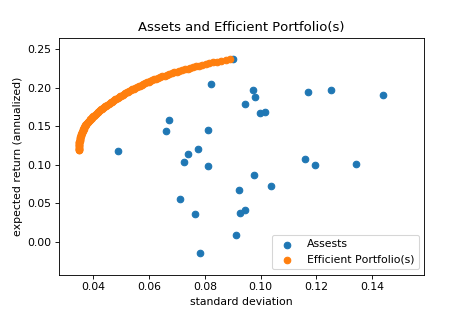

In [10]:
c1 = time()
#Define minimal return
beta = np.arange(0.118,0.238,0.001)
b = beta.size
#Matrix for optimum points (column i contains coordinates to optimum point to beta[i])
x_opt = np.zeros([n,b])
val_opt = np.zeros(b)
def f0(x):
    return f(x, C)
def phelp0(f, x, A):
    return algorithmus1(f, x, armijo_rule, A, tol)
#loop over all returns
for i in range(0,b):
    print(beta[i])
    #Generate starting vector
    x0 = startval(mu, beta[i])
    #Adapt ineq. restrictions
    def g0(x):
        return g(x, mu, beta[i])
    #Execute algorithm and save optimum point (and values)
    x_opt[:,i], val_opt[i] = algorithmus2(f0, g0, A, z, alpha, tau, x0, theta, phelp0)

c2 = time()
print('Dauer: ', c2-c1)
#Visualization of the results
create_plot(x_opt, mu, C)